In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### **종목 선정 모델 개발**

이번절에서는 책에서 종목선정을 위해 사용할 GAM 모델을 개발하겠습니다. 아나콘다 프롬프트에서 conda install -c conda-forge pygam 로 설치를 해 줍니다. 관련 링크 https://anaconda.org/conda-forge/pygam

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 5% 익절은 다음과 같이 데이터로 표현할 수 있습니다. - 'max_close' 가 5% 이상일 때 1, 아니면 0. 파이썬 코드는 아래와 같습니다.
```python
np.where(feature_all['max_close']>= 1.05, 1, 0)
``` 
타겟 변수 - 'target' 값이 1 인 비율을 보니, 약 24% 입니다. 타겟변수의 비율이 너무 적으면 모델 트레이닝이 어렵습니다. 

In [2]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.3%


<br> 날짜와 종목은 모델의 입력피처가 아닙니다. 편의를 위해 제거하거나 인덱스로 처리합니다. 모델 트레이닝 용도로 10,000 개 샘플을 뽑아 예측모델을 만들고, 나머지 데이터는 테스트(혹은 백테스팅)를 하겠습니다.  

In [3]:
mdl_all = feature_all.drop(columns=['max_close', 'sector']).set_index([feature_all.index,'code'])

train = mdl_all.sample(5000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]
print(len(train), len(test))

5000 325186


입력 피처의 갯수와 데이터타입을 확인합니다.

In [4]:
train.drop(columns=['target']).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5000 entries, (Timestamp('2022-01-19 00:00:00'), '213420') to (Timestamp('2022-01-26 00:00:00'), '189860')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_z             5000 non-null   float64
 1   volume_z            5000 non-null   float64
 2   num_high/close      5000 non-null   float64
 3   num_long            5000 non-null   float64
 4   num_z>1.96          5000 non-null   float64
 5   num_win_market      5000 non-null   float64
 6   pct_win_market      5000 non-null   float64
 7   return over sector  5000 non-null   float64
dtypes: float64(8)
memory usage: 385.2+ KB


In [30]:
from pygam import LogisticGAM, s, f, te, l
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

X = train.drop(columns='target')
y = train['target']
X_test = test.drop(columns='target')
y_test = test['target']

lambda_list = np.logspace(-3, 3, 7)

accuracy_list = []
logloss_list = []

for lam in lambda_list:
    
    gam = LogisticGAM(te(0, 1, n_splines=5) + s(0) + s(1) + s(2) + f(3) + s(6) + s(7), lam = lam).fit(X.to_numpy(), y.to_numpy())
    
    pred = gam.predict(X_test)
    prob = gam.predict_proba(X_test)
    
    print(f'{lam}:{accuracy_score(y_test, pred):5.4f}, log loss:{log_loss(y_test, prob):5.4f}')
    
    accuracy_list.append(accuracy_score(y_test, pred)) 
    logloss_list.append(log_loss(y_test, prob)) 

print(gam.summary())
print(gam.accuracy(X_test, y_test))    

0.001:0.7525, log loss:0.5570
0.01:0.7531, log loss:0.5507
0.1:0.7541, log loss:0.5468
1.0:0.7554, log loss:0.5443
10.0:0.7564, log loss:0.5433
100.0:0.7566, log loss:0.5443
1000.0:0.7569, log loss:0.5465
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.4012
Link Function:                        LogitLink Log Likelihood:                                 -2776.3105
Number of Samples:                         5000 AIC:                                             5573.4235
                                                AICc:                                            5573.4802
                                                UBRE:                                               3.1163
                                              

<br> 각 변수별로 다른 'lambda' (Wiggliness Penalty Weight) 을 적용해서 grid Search 를 합니다. spline 수는 20 이 default 값입니다. spline 수는 고정하고 lambda의 최적 조합을 찾거나, lambda 를 고정하고, spline 수의 최적 조합을 찾는 것이 현실적이고, 두 하이퍼파라미터를 동시에 조합하여 grid Search 하는 것은 시간이 많이 걸립니다. 다양한 시도를 통하여 더 좋은 모델을 구현할 수 있겠으나, 이 책에서는 grid search 로 변수별 최적의 lambda 를 찾는 것으로 모델을 완성합니다. P value 가 크게 나타나는 입력변수는 제거하는 것이 좋겠습니다.

In [37]:
from pygam import LogisticGAM, s, f, te, l
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']
X = train[feature_list]
y = train['target']
X_test = test[feature_list]
y_test = test['target']

# 하이퍼파라미터 설정 N 개의 변수면 (M x N) 개의 리스트로 생성함으로써 변수별로 다른 하이퍼파라미터 테스트 가능. 
# M 개만 1D 리스트를 만들면 동일한 lambda 른 모든 변수에 적용함.
lam_list = [np.logspace(0, 3, 2)]*8
   
gam = LogisticGAM(te(0, 1, n_splines=5) + s(1) + s(2) + s(3) + s(4) + te(4, 5, n_splines=5)).gridsearch(X.to_numpy(), y.to_numpy(), lam=lam_list) 

print(gam.summary())
print(gam.accuracy(X_test, y_test))

100% (256 of 256) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     19.2936
Link Function:                        LogitLink Log Likelihood:                                 -2754.9206
Number of Samples:                         5000 AIC:                                             5548.4285
                                                AICc:                                            5548.6021
                                                UBRE:                                               3.1128
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0232
Feature Function                  Lam

In [38]:
for i, term in enumerate(gam.terms):
    print(i, term)

0 tensor_term
1 spline_term
2 spline_term
3 spline_term
4 spline_term
5 tensor_term
6 intercept_term


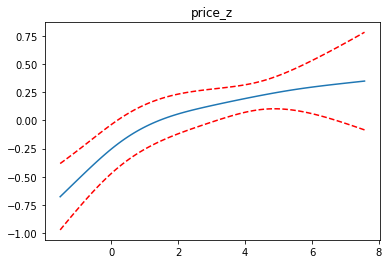

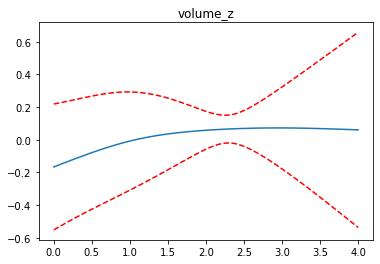

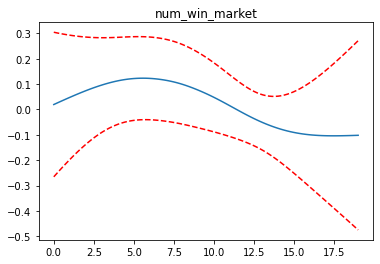

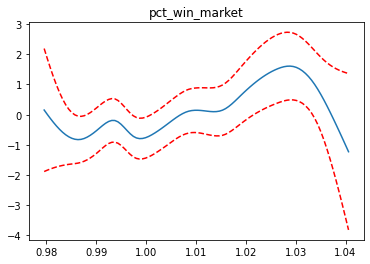

In [41]:
for i, term in enumerate(gam.terms):
    
    if i>=1 and i<=4:

        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        plt.figure()
        plt.plot(XX[:, term.feature], pdep)
        plt.plot(XX[:, term.feature], confi, c='r', ls='--')
        plt.title(titles[i])
        plt.show()

<br> 완성된 모델을 pickle 로 binary 파일로 저장합니다.

In [42]:
import pickle
with open("gam.pkl", "wb") as file:
    pickle.dump(gam, file)    

In [43]:
with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

In [44]:
print(gam.get_params())
print(gam.coef_.shape)

{'max_iter': 100, 'tol': 0.0001, 'callbacks': [Deviance(), Diffs(), Accuracy()], 'verbose': False, 'terms': te(0, 1) + s(1) + s(2) + s(3) + s(4) + te(4, 5) + intercept, 'fit_intercept': True}
(131,)


In [45]:
for i in range(6):
    print(f'{i}: {gam._compute_p_value(i): 5.3f} {gam.generate_X_grid(term=i).shape}')

0:  0.000 (10000, 6)
1:  0.005 (100, 6)
2:  0.546 (100, 6)
3:  0.183 (100, 6)
4:  0.000 (100, 6)
5:  0.114 (10000, 6)


<br> 간단하게 십분위수 분석을 하고, 성능을 평가합니다. 안정적인 모델을 만들었습니다. 이론적으로는 마지막 Decile(제 10 십분위 수)에서 랜덤하게 종목을 골라 동일한 금액으로 매수를 한다면, 5 영업일이내 5% 익절할 확률이 37% 가 됩니다.  100% 만족스럽지는 않지만, 생성된 GAM 모델을 이용하여 종목 추천을 받도록 하겠습니다.

In [46]:
yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

yhat_test = gam.predict_proba(X_test.to_numpy())
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index)

                              count  mean
yhat                                     
(0.06319999999999999, 0.186]    500 0.174
(0.186, 0.2]                    500 0.172
(0.2, 0.212]                    500 0.208
(0.212, 0.224]                  500 0.208
(0.224, 0.236]                  500 0.244
(0.236, 0.25]                   500 0.222
(0.25, 0.27]                    500 0.258
(0.27, 0.298]                   500 0.296
(0.298, 0.34]                   500 0.322
(0.34, 0.677]                   500 0.412
                count  mean
yhat                       
(0.074, 0.185]  32519 0.174
(0.185, 0.199]  32519 0.177
(0.199, 0.21]   32518 0.191
(0.21, 0.222]   32519 0.204
(0.222, 0.235]  32518 0.219
(0.235, 0.25]   32519 0.240
(0.25, 0.27]    32518 0.258
(0.27, 0.297]   32519 0.277
(0.297, 0.339]  32518 0.319
(0.339, 0.959]  32519 0.366


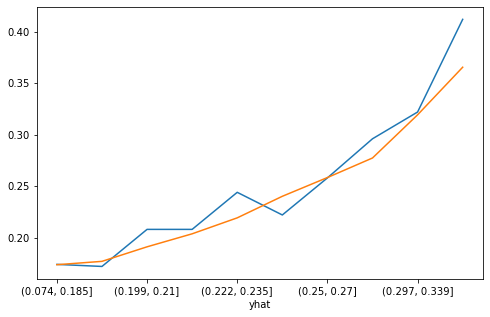

In [47]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot(figsize=(8,5))

perf(y, yhat)
perf(y_test, yhat_test)

In [48]:
print(feature_all.index.min(), feature_all.index.max())

2021-04-01 00:00:00 2022-03-24 00:00:00
